---

# <center>★  Implementation - Inception ★

|![Inception V3](https://www.researchgate.net/publication/342431074/figure/fig4/AS:906143102668804@1593052759822/Architecture-of-the-InceptionV3-model.png)|
|:--------------------------------------------------:|

### Objective:
- Understand the Model Architecture
- Reconstruct the Model Architecture from scratch
- Perform a dry run test to assess it's implemenation on real-time data.

---

### Inception V3 Model Description:

Convolutional Neural Networks (CNNs) have evolved significantly, from LeNet-style, AlexNet, and VGG models, which used simple stacks of convolutional layers for feature extraction and max-pooling layers for spatial sub-sampling, to more sophisticated architectures like Inception and ResNet networks, which use multiple convolutional and pooling blocks within each layer and skip connections.

Since its introduction, one of the most influential networks in computer vision has been the **Inception family**. Inception V3 improves upon earlier versions by using factorized convolutions, efficient grid size reduction, and auxiliary classifiers, allowing the network to learn rich feature representations while keeping computational costs manageable.

Inception V3 paper — [https://arxiv.org/abs/1512.00567](https://arxiv.org/abs/1512.00567)

The Inception V3 architecture has several main components, organized into **stems**, **Inception modules**, and **reduction modules**.

---

#### Stem of the Inception V3 architecture (Source: Image from the original paper)

The stem consists of several convolutional layers with ReLU activations, designed to reduce the spatial dimensions of the input image while increasing the depth (number of channels). The diagram specifies the number of filters, kernel sizes, strides, and padding.

* Convolutional layers are followed by batch normalization.
* Max pooling layers are used for downsampling.
* Input images typically start at **299×299×3**. After the stem, the feature map size is reduced significantly, preparing the input for the Inception modules.

---

#### Inception modules and Reduction modules (Source: Image from the original paper)

The main body of the network consists of **Inception modules**, each containing multiple parallel convolutional paths of different filter sizes (1×1, 3×3, 5×5, factorized as needed) and pooling layers. The outputs of these paths are concatenated along the channel dimension, allowing the network to capture multi-scale features efficiently.

* Factorized convolutions (e.g., 7×1 followed by 1×7) reduce computational cost while maintaining the receptive field.
* Reduction modules are used periodically to reduce the spatial dimensions while increasing depth.
* Auxiliary classifiers are added during training to help propagate gradients.
* All convolutional layers are followed by batch normalization.

---

#### Output and Classification

At the end of the network, global average pooling is applied to reduce the feature map to a 1D vector, which is fed into a fully connected layer with softmax activation for classification.

* Input image size: **299×299×3**
* Output: class probabilities over the target classes

---

## <center> Stractegic Plan of Action:
    
**Here are some of the necessary steps:**
1. Dataset Prepration
2. Model Development
3. Model Testing
4. Conclusion

---

In [1]:
! pip install torchinfo

In [2]:
import torch

num_gpus = torch.cuda.device_count()
print(f'Number of GPUs available: {num_gpus}')

# Optionally, print the name of each GPU
for i in range(num_gpus):
    print(f'GPU {i}: {torch.cuda.get_device_name(i)}')


Number of GPUs available: 2
GPU 0: Tesla T4
GPU 1: Tesla T4


## <center> 1. Dataset Prepration

In [3]:
#Importing the basic librarires

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

# Preparing the dataset

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

# Preparing the dataset
# Define preprocessing for training and validation
transform_train = transforms.Compose([
    transforms.Resize((320, 320)),  # Resize to allow random cropping
    transforms.RandomResizedCrop(299),  # Random crop to 299x299
    transforms.RandomHorizontalFlip(),  # Augmentation for training
    transforms.ToTensor(),  # Convert to tensor (scales to [0, 1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize directly to 299x299
    transforms.CenterCrop(299),  # Center crop for consistency
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Download and load CIFAR10 training data
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Split train set into training and validation (e.g., 45k train, 5k val)
train_size = int(0.9 * len(full_trainset))
val_size = len(full_trainset) - train_size
train_set, val_set = random_split(full_trainset, [train_size, val_size])

# For validation, use test transform (no augmentation)
val_set.dataset.transform = transform_test

# Load CIFAR10 test dataset
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


---

## <center>2. Model Development

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Load Inception V3 model
# Set pretrained=True to use ImageNet pretrained weights, or False for random initialization
model = models.inception_v3(pretrained=False, init_weights=True)

num_classes = 10  # Adjust to your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)

# Checking Model Summary
from torchinfo import summary
summary(model, input_size=(1, 3, 299, 299))


Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [1, 10]                   2,565,386
├─BasicConv2d: 1-1                       [1, 32, 149, 149]         --
│    └─Conv2d: 2-1                       [1, 32, 149, 149]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 149, 149]         64
├─BasicConv2d: 1-2                       [1, 32, 147, 147]         --
│    └─Conv2d: 2-3                       [1, 32, 147, 147]         9,216
│    └─BatchNorm2d: 2-4                  [1, 32, 147, 147]         64
├─BasicConv2d: 1-3                       [1, 64, 147, 147]         --
│    └─Conv2d: 2-5                       [1, 64, 147, 147]         18,432
│    └─BatchNorm2d: 2-6                  [1, 64, 147, 147]         128
├─MaxPool2d: 1-4                         [1, 64, 73, 73]           --
├─BasicConv2d: 1-5                       [1, 80, 73, 73]           --
│    └─Conv2d: 2-7                       [1, 80, 73, 73]           5,

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = torch.randn(1, 3, 299, 299).to(device)
model = model.to(device)
model.eval()
model(input_tensor)

tensor([[-3.1748e+10,  3.6815e+11,  2.8829e+11, -5.5844e+11,  3.2708e+11,
          1.8377e+11,  1.9540e+11, -2.2193e+11,  2.4136e+11,  8.5197e+10]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

## <center>3. Model Training

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import json

# Assume model, train_loader, val_loader defined and moved to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.nn.DataParallel(model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scaler = GradScaler()  # For dynamic gradient scaling
import time

import torch
from torch.cuda.amp import autocast, GradScaler

def train_and_validate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=5):
    scaler = torch.cuda.amp.GradScaler()
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'time_per_epochs': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        start = time.time()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs.logits, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs.logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        step_time = time.time() - start
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = running_loss / total
        val_acc = correct / total
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Save metrics for each epoch
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['time_per_epochs'].append(step_time)

    # Convert dictionary to JSON string
    history =  json.dumps(history) 
    
    # Option 2: Write the JSON string  to a file
    with open('history_inceptionv3.json', 'w') as f:
        f.write(history)
        
    return model, history



# model, history = train_and_validate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

# Final evaluation on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


Test Loss: 171906618438.4512 | Test Accuracy: 0.1000


In [8]:
num_epochs = 10
model, history = train_and_validate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs)

Epoch 1 | Train Loss: 1.4864 | Train Acc: 0.4597 | Val Loss: 1.3155 | Val Acc: 0.5384
Epoch 2 | Train Loss: 0.9234 | Train Acc: 0.6780 | Val Loss: 1.1181 | Val Acc: 0.6266
Epoch 3 | Train Loss: 0.6539 | Train Acc: 0.7746 | Val Loss: 0.6839 | Val Acc: 0.7646
Epoch 4 | Train Loss: 0.5100 | Train Acc: 0.8239 | Val Loss: 0.6182 | Val Acc: 0.7878
Epoch 5 | Train Loss: 0.4117 | Train Acc: 0.8573 | Val Loss: 0.6026 | Val Acc: 0.7960
Epoch 6 | Train Loss: 0.3404 | Train Acc: 0.8842 | Val Loss: 0.5094 | Val Acc: 0.8356
Epoch 7 | Train Loss: 0.2833 | Train Acc: 0.9020 | Val Loss: 0.5594 | Val Acc: 0.8320
Epoch 8 | Train Loss: 0.2366 | Train Acc: 0.9189 | Val Loss: 0.4987 | Val Acc: 0.8414
Epoch 9 | Train Loss: 0.1940 | Train Acc: 0.9328 | Val Loss: 0.4397 | Val Acc: 0.8630
Epoch 10 | Train Loss: 0.1663 | Train Acc: 0.9414 | Val Loss: 0.4722 | Val Acc: 0.8604


In [9]:
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'inceptionv3_model.pth')


In [10]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Test Loss: 0.4810 | Test Accuracy: 0.8544


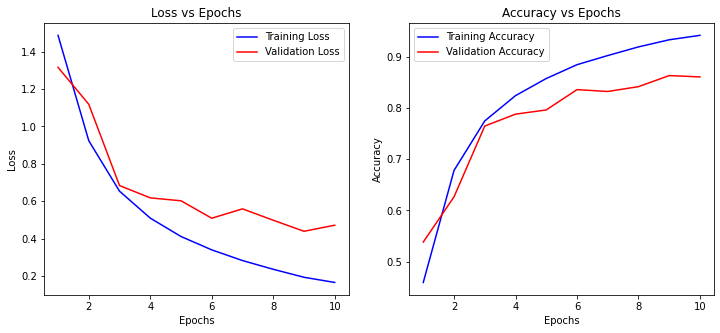

In [11]:
# Final evaluation on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
history = json.loads(history)
plot_training_history(history)

---

# <center>4. Project Outcomes & Conclusion

### Here are some of the key outcomes of the project:

- The Model Architecture was reconstructed from pytorch api with no errors.
- We were able to plot the model graph & observe input & output shapes of all the layers. 
- Also we could identify that the total trainable paramters for the Inception V3 model were 24.37M.
- To demonstrate it's functionality, we have tested the model for just 10 epochs (due to hardware limitations). 
- Despite this, the model has performed surpisingly well achieving high accuracy within few iterations.

In [12]:
#<<<--------------------------------------THE END---------------------------------------->>>